In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional

In [ ]:
@dataclass
class InflationaryParameters:
    N_e : float  # Number of e-folds
    n_s: float # Spectral index
    r: float # Tensor-to-scalar ratio
    phi_end: float # Field value at end of inflation
    phi_star: float # Field value 60 e-folds before end

In [ ]:
class InflationaryPotential:
    def __init__(self, coefficients: np.ndarray, max_degree: int = 6):
        self.coefficients = coefficients
        self.max_degree = max_degree

    def V(self, phi: float) -> float:
        return sum(self.coefficients[n] * phi ** n for n in range(len(self.coefficients)))

    def dV_dphi(self, phi: float) -> float:
        return sum(n * self.coefficients[n] * phi ** (n-1) for n in range(1, len(self.coefficients)))

    def d2V_dphi2(self, phi: float) -> float:
        return sum(n * (n-1) * self.coefficients[n] * phi ** (n-2) for n in range(2, len(self.coefficients)))

In [ ]:
def slow_roll_parameters(potential: InflationaryPotential, phi: float) -> Tuple[float, float]:
    V = potential.V(phi)
    dV = potential.dV_dphi(phi)
    d2V = potential.d2V_dphi2(phi)

    epsilon = 0.5 * (dV / V)**2
    eta = d2V / V

    if not np.isfinite(epsilon) or not np.isfinite(eta):
        return float('nan'), float('nan')

    return epsilon, eta

def calculate_inflation_parameters(
        potential: InflationaryPotential,
        phi_initial: float = 15.0,
        phi_final: float = 0.1) -> Optional[InflationaryParameters]:

    try:
        phi_end = None
        phi_vals = np.linspace(phi_final, phi_initial, 1000)

        for phi in phi_vals:
            epsilon, eta = slow_roll_parameters(potential, phi)
            if epsilon >= 1.0:
                phi_end = phi
                break

        if phi_end is None:
            return None

        # Calculate number of e-folds
        def efolds_integrand(phi):
            epsilon, _ = slow_roll_parameters(potential, phi)
            if epsilon <= 0 or epsilon >= 1:
                return 0
            return 1.0 / np.sqrt(2 * epsilon)

        # Integrate to find phi_star
        N_target = 60.0
        phi_star = None
        N_current = 0

        phi_vals_detailed = np.linspace(phi_end, phi_initial, 5000)
        dphi = phi_vals_detailed[1] - phi_vals_detailed[0]

        for i, phi in enumerate(phi_vals_detailed[1:], 1):
            dN = efolds_integrand(phi) * dphi
            N_current += dN

            if N_current >= N_target and phi_star is None:
                phi_star = phi
                break

        if phi_star is None or N_current < N_target:
            return None

        epsilon_star, eta_star = slow_roll_parameters(potential, phi_star)

        if epsilon_star <= 0 or epsilon_star >= 1:
            return None

        n_s = 1 - 6*epsilon_star + 2*eta_star
        r = 16*epsilon_star

        return InflationaryParameters(
            N_e=N_current,
            n_s=n_s,
            r=r,
            phi_end=phi_end,
            phi_star=phi_star
        )

    except (ValueError, ZeroDivisionError, OverflowError):
        return None

In [ ]:
def fitness_function(potential: InflationaryPotential) -> float:
    params = calculate_inflation_parameters(potential)

    if params is None:
        return 0.0

    fitness = 0.0

    # E-folds constraint (N_e >= 60)
    if params.N_e >= 60:
        fitness += 100
        if 60 <= params.N_e <= 70:
            fitness += 50
        elif params.N_e > 100:
            fitness -= 20
    else:
        fitness -= 50

    # Spectral index constraint (0.960 <= n_s <= 0.970)
    if 0.960 <= params.n_s <= 0.970:
        fitness += 100
        fitness += 50 * (1 - abs(params.n_s - 0.965) / 0.005)
    else:
        if params.n_s < 0.960:
            fitness -= 50 * (0.960 - params.n_s) / 0.01
        else:
            fitness -= 50 * (params.n_s - 0.970) / 0.01

    if params.r <= 0.07:
        fitness += 50
        if params.r > 0:
            fitness += 25 * (1 - params.r / 0.07)
    else:
        fitness -= 100 * (params.r - 0.07) / 0.07

    coeff_penalty = np.sum(np.abs(potential.coefficients)) * 0.1
    fitness -= coeff_penalty

    return max(0, fitness)

#### Genetic algorithm Begins

In [ ]:
class GeneticAlgorithm:
    def __init__(self,
                 population_size: int = 100,
                 max_degree: int = 6,
                 mutation_rate: float = 0.1,
                 crossover_rate: float = 0.8
                 ):
        self.population_size = population_size
        self.max_degree = max_degree
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.generation = 0
        self.best_fitness_history = []
        self.avg_fitness_history = []

    def initialize_population(self) -> List[InflationaryPotential]:
        population = []

        for _ in range(self.population_size):
            coefficients = np.random.normal(0, 1, self.max_degree + 1)
            if self.max_degree > 0:
                coefficients[-1] = abs(coefficients[-1]) + 0.1

            # Scale down higher order terms
            for i in range(len(coefficients)):
                coefficients[i] /= (i + 1)**0.5

            population.append(InflationaryPotential(coefficients, self.max_degree))

        return population

    def tournament_selection(self, population: List[InflationaryPotential],
                           fitnesses: List[float], tournament_size: int = 3) -> InflationaryPotential:
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
        winner_idx = tournament_indices[np.argmax(tournament_fitnesses)]
        return population[winner_idx]

    def crossover(self, parent1: InflationaryPotential,
                  parent2: InflationaryPotential) -> Tuple[InflationaryPotential, InflationaryPotential]:
        if random.random() > self.crossover_rate:
            return parent1, parent2

        crossover_point = random.randint(1, len(parent1.coefficients) - 1)

        child1_coeffs = np.concatenate([
            parent1.coefficients[:crossover_point],
            parent2.coefficients[crossover_point:]
        ])

        child2_coeffs = np.concatenate([
            parent2.coefficients[:crossover_point],
            parent1.coefficients[crossover_point:]
        ])

        return (InflationaryPotential(child1_coeffs, self.max_degree),
                InflationaryPotential(child2_coeffs, self.max_degree))

    def mutate(self, potential: InflationaryPotential) -> InflationaryPotential:
        """Gaussian mutation"""
        coefficients = potential.coefficients.copy()

        for i in range(len(coefficients)):
            if random.random() < self.mutation_rate:
                # Adaptive mutation strength
                mutation_strength = 0.1 / (i + 1)**0.5
                coefficients[i] += np.random.normal(0, mutation_strength)

        # Ensure positive definite potential
        if self.max_degree > 0 >= coefficients[-1]:
            coefficients[-1] = abs(coefficients[-1]) + 0.1

        return InflationaryPotential(coefficients, self.max_degree)


    def evolve_generation(self, population: List[InflationaryPotential]) -> List[InflationaryPotential]:
        fitnesses = [fitness_function(pot) for pot in population]

        # Track statistics
        best_fitness = max(fitnesses)
        avg_fitness = np.mean(fitnesses)
        self.best_fitness_history.append(best_fitness)
        self.avg_fitness_history.append(avg_fitness)

        print(f"Generation {self.generation}: Best fitness = {best_fitness:.2f}, "
              f"Avg fitness = {avg_fitness:.2f}")

        new_population = []

        # Elitism
        best_idx = np.argmax(fitnesses)
        new_population.append(population[best_idx])

        while len(new_population) < self.population_size:
            parent1 = self.tournament_selection(population, fitnesses)
            parent2 = self.tournament_selection(population, fitnesses)

            child1, child2 = self.crossover(parent1, parent2)

            child1 = self.mutate(child1)
            child2 = self.mutate(child2)

            new_population.extend([child1, child2])

        # Trim to exact population size
        new_population = new_population[:self.population_size]
        self.generation += 1

        return new_population


    def run(self, generations: int = 50) -> Tuple[InflationaryPotential, List[InflationaryPotential]]:
        """Run the genetic algorithm"""
        print(f"Starting genetic algorithm with {self.population_size} individuals "
              f"for {generations} generations...")
        print(f"Polynomial degree: {self.max_degree}")
        print(f"Mutation rate: {self.mutation_rate}, Crossover rate: {self.crossover_rate}")
        print("-" * 60)

        population = self.initialize_population()

        for gen in range(generations):
            population = self.evolve_generation(population)

        # Find and return best individual
        final_fitnesses = [fitness_function(pot) for pot in population]
        best_idx = np.argmax(final_fitnesses)
        best_potential = population[best_idx]

        print("-" * 60)
        print(f"Evolution complete! Best fitness: {max(final_fitnesses):.2f}")

        return best_potential, population

In [ ]:
def analyze_potential(potential: InflationaryPotential, title: str = "Inflationary Potential"):
    params = calculate_inflation_parameters(potential)

    print(f"\n{title}")
    print("=" * len(title))
    print(f"Coefficients: {potential.coefficients}")

    if params:
        print(f"Number of e-folds: {params.N_e:.2f}")
        print(f"Spectral index n_s: {params.n_s:.4f}")
        print(f"Tensor-to-scalar ratio r: {params.r:.4f}")
        print(f"Field value at end of inflation: {params.phi_end:.3f}")
        print(f"Field value 60 e-folds before end: {params.phi_star:.3f}")
        print(f"Fitness score: {fitness_function(potential):.2f}")
    else:
        print("Failed to calculate inflationary parameters")

    phi_vals = np.linspace(0.1, 20, 1000)
    V_vals = [potential.V(phi) for phi in phi_vals]

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(phi_vals, V_vals, 'b-', linewidth=2)
    plt.xlabel('φ')
    plt.ylabel('V(φ)')
    plt.title('Potential')
    plt.grid(True, alpha=0.3)

    if params:
        plt.axvline(params.phi_end, color='r', linestyle='--', label=f'φ_end = {params.phi_end:.2f}')
        plt.axvline(params.phi_star, color='g', linestyle='--', label=f'φ_* = {params.phi_star:.2f}')
        plt.legend()

    plt.subplot(1, 2, 2)
    epsilon_vals = []
    eta_vals = []

    for phi in phi_vals:
        eps, eta = slow_roll_parameters(potential, phi)
        epsilon_vals.append(min(eps, 10))  # Cap for visualization
        eta_vals.append(max(-10, min(eta, 10)))  # Cap for visualization

    plt.plot(phi_vals, epsilon_vals, 'r-', label='ε', linewidth=2)
    plt.plot(phi_vals, eta_vals, 'b-', label='η', linewidth=2)
    plt.axhline(1, color='k', linestyle='--', alpha=0.5, label='ε = 1')
    plt.xlabel('φ')
    plt.ylabel('Slow-roll parameters')
    plt.title('Slow-roll Parameters')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

Starting genetic algorithm with 100 individuals for 20 generations...
Polynomial degree: 6
Mutation rate: 0.15, Crossover rate: 0.8
------------------------------------------------------------
Generation 0: Best fitness = 0.00, Avg fitness = 0.00
Generation 1: Best fitness = 0.00, Avg fitness = 0.00
Generation 2: Best fitness = 0.00, Avg fitness = 0.00
Generation 3: Best fitness = 0.00, Avg fitness = 0.00
Generation 4: Best fitness = 0.00, Avg fitness = 0.00
Generation 5: Best fitness = 0.00, Avg fitness = 0.00
Generation 6: Best fitness = 0.00, Avg fitness = 0.00
Generation 7: Best fitness = 0.00, Avg fitness = 0.00
Generation 8: Best fitness = 0.00, Avg fitness = 0.00
Generation 9: Best fitness = 0.00, Avg fitness = 0.00
Generation 10: Best fitness = 0.00, Avg fitness = 0.00
Generation 11: Best fitness = 0.00, Avg fitness = 0.00
Generation 12: Best fitness = 0.00, Avg fitness = 0.00
Generation 13: Best fitness = 0.00, Avg fitness = 0.00
Generation 14: Best fitness = 0.00, Avg fitness

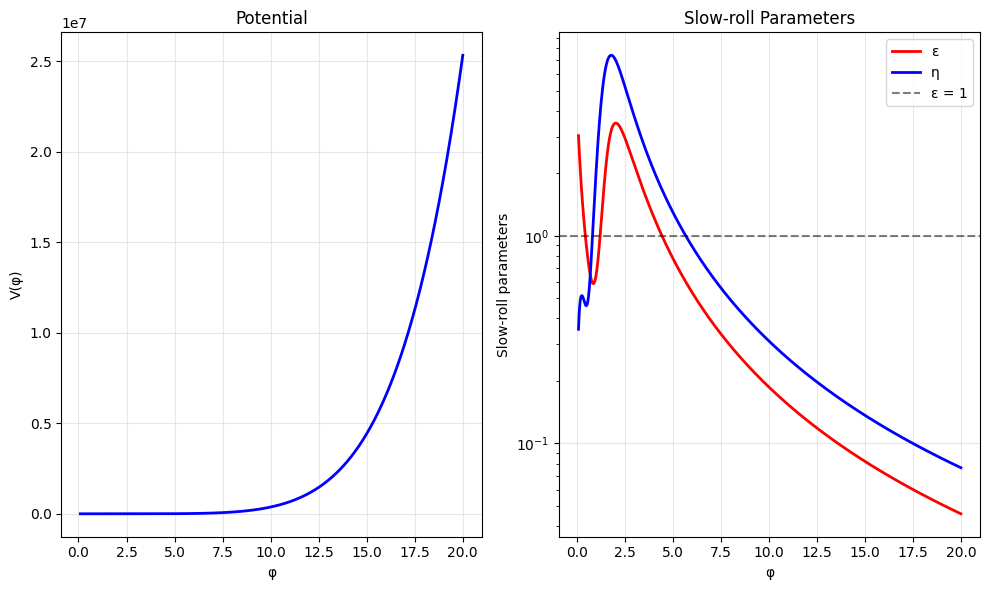

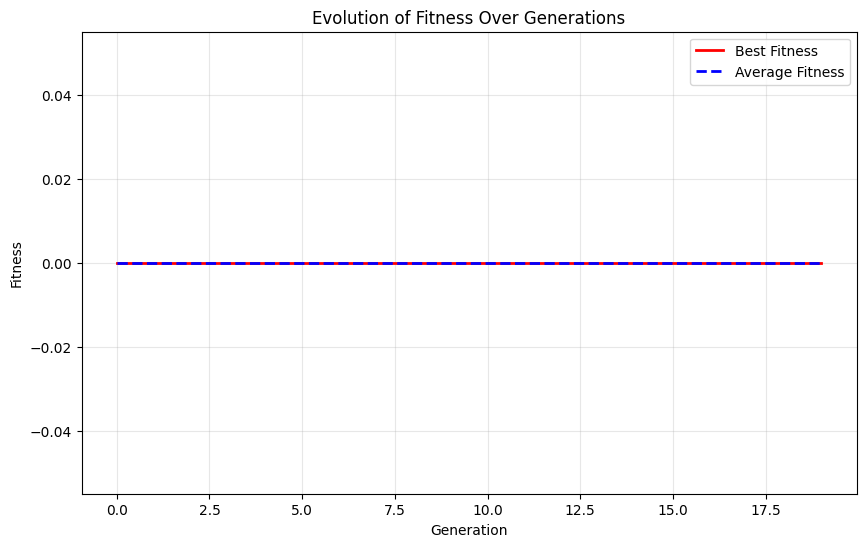

In [18]:
# Initialize and run genetic algorithm
ga = GeneticAlgorithm(
population_size=100,
max_degree=6,
mutation_rate=0.15,
crossover_rate=0.8
)

best_potential, final_population = ga.run(generations=20)

# Analyze best potential
analyze_potential(best_potential, "Best Evolved Potential")

# Plot evolution history
plt.figure(figsize=(10, 6))
plt.plot(ga.best_fitness_history, 'r-', linewidth=2, label='Best Fitness')
plt.plot(ga.avg_fitness_history, 'b--', linewidth=2, label='Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Evolution of Fitness Over Generations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
### There is something wrong with the previous code, I am not able to get the genetic algorithm to optimise all the cosmological parameters properly.